[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/colabs/activity-and-roles-detection.ipynb)


# SIGNAL*ing* `communication network patterns`

##### **Copyright 2022 SRI International.**

This project is under the GPL3 License. 
See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

# 🏃‍♀️ Quickstart

## 🪄 Install `needed` libraries

In [63]:
from __future__ import annotations

import math
import os
import sys
import typing as ty
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from bistiming import Stopwatch
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, StandardScaler

In [64]:
warnings.filterwarnings('ignore')

## ⚙ Define `processing` functions

In [36]:
def int_list(sequence):
  """Given a sorted list A of elements, return a sorted list B of integers
  starting at 0, where each unique value in A has one and only one equivalent
  in B"""

  result = list(range(0, len(sequence)))

  for i in range(1, len(sequence)):
    if sequence[i] == sequence[i-1]:
      result[i] = result[i-1]
    else:
      result[i] = result[i-1] + 1

  return result

In [38]:
def rect_dimension(integer):
  """Find dimension x of a rectangle that can contain all values of
  a range from 1 to integer while keeping rectangle as close to a square as
  possible"""

  sqrt = math.floor(math.sqrt(integer))
  m1 = 0

  for i in reversed(range(1, sqrt+1)):
    remainder = integer % i

    if remainder == 0:
      m1 = i
      break

  # Prime numbers
  if m1 == 1:
    m1 = sqrt

  return m1

In [39]:
def rect_list(sequence):
  chunk = rect_dimension(len(sequence))
  result = list(zip(*[iter(sequence)] * chunk))

  diff = len(sequence) % chunk
  if diff > 0:
    row = sequence[-diff:]

    # Add NAN to have a full row of elements
    missing = len(result[0]) - len(row)
    print(missing)
    row.extend([np.nan] * missing)
    print(row)

    result.append(tuple(row))

  return result

In [40]:
def log_norm_transform(data_series: pd.Series) -> ty.Union[ty.Any, tuple]:
  """Returns the data after applying log and standardization it."""
  data = np.nan_to_num(data_series)
  result = np.nan_to_num(np.log1p(data))
  std_scaler = StandardScaler()
  std_scaler.fit(result)
  return std_scaler.transform(result)

## ⊕ Define `plotting` functions

In [103]:
def heatmap_count(df, var_list, show=True):
  """Draw heatmap count of two variables"""
  plt.figure(figsize=(10,5))
  # Count unique rows
  with Stopwatch("heatmap_count"):
    count = df.groupby(var_list).size().reset_index(name='n')
    count = count.pivot(*var_list, 'n')
    sns.heatmap(count)

  if show:
    plt.show()

In [104]:
def ordered_mosaic(df, var_list, show=True):
  """Ordered mosaic"""
  plt.figure(figsize=(10,5))
  with Stopwatch("Ordered mosaic"):
    # Get values sorted by variables
    mosaic = df[var_list].sort_values(var_list).values

    # Labels for annotation
    labels = ['|'.join([str(elt) for elt in pair]) for pair in mosaic]

    # Prepare the matrix with dummy values
    values = int_list(labels)

    # Give the values and the labels the same shape
    values = np.array(rect_list(values))
    labels = np.array(rect_list(labels))

    mosaic = sns.heatmap(values, annot=labels, fmt='', cbar=False, xticklabels=False, yticklabels=False)
    mosaic.set_title('Descending ordered list of {} | {}'.format(*var_list))

  if show:
    plt.show()

In [44]:
def build_data_filter(threads_df: pd.DataFrame, comparator: str = ">", no_emails_in_threads: int = 10) -> bool:
  data_filter_pred = None
  if comparator == ">":
    data_filter_pred = threads_df.emails > no_emails_in_threads
  elif comparator == ">=":
    data_filter_pred = threads_df.emails >= no_emails_in_threads
  elif comparator == "==":
    data_filter_pred = threads_df.emails == no_emails_in_threads
  elif comparator == "<=":
    data_filter_pred = threads_df.emails <= no_emails_in_threads
  elif comparator == "<":
    data_filter_pred = threads_df.emails < no_emails_in_threads
  else:
    raise ValueError(f"unknown comparator {comparator} was given")
  
  return data_filter_pred

In [87]:
def plot_correlation_circle(self, components: ty.Tuple[int] =(1, 2)) -> None:
  """Draw a correlation circle.
  :components: PC numbers to be used on the x and y axis
  :show: display the graph
  """

  # Create figure
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 1, 1)

  # Keep figure square
  ax.set_aspect('equal')

  # Center axis around (0,0)
  ax.spines['left'].set_position('zero')
  ax.spines['bottom'].set_position('zero')

  # Eliminate upper and right axes
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')

  # Keep ticks on bottom and left axis and make them protrude in both directions
  ax.xaxis.set_tick_params(bottom=True, top=False, direction='inout')
  ax.yaxis.set_tick_params(left=True, right=False, direction='inout')

  # Center the graph and make it square
  ax.set_yticks([-1.0, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1.0])
  ax.set_xticks([-1.0, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1.0])

  # Draw a circle of radius 1
  circle1 = plt.Circle((0, 0), radius=1, color='black', fill=False)
  ax.add_artist(circle1)

  # Get colors for each vector arrow
  cmap = plt.cm.get_cmap('Accent', len(self.features))

  for feature in range(0, len(self.features)):
    # Get coordinates of the "arrow head" along both components
    x = self.pca.components_[components[0]-1, feature]
    y = self.pca.components_[components[1]-1, feature]

    # Compute coordinates for annotation
    anot_x = x + 0.05 if x > 0 else x - 0.05
    anot_y = y + 0.05 if y > 0 else y - 0.05

    ax.arrow(0, 0, # Vector arrow starts at (0, 0)
             x, y, # Arrow head coordinates
             color=cmap(feature),
             head_width=0.03, 
             head_length=0.03)

    # Add arrow annotation
    ax.annotate(self.features[feature], xy=(anot_x, anot_y), color=cmap(feature))

  # Get explained variances as percentage for each component
  exp_var_cp1 = round(self.pca.explained_variance_ratio_[components[0]-1] * 100)
  exp_var_cp2 = round(self.pca.explained_variance_ratio_[components[1]-1] * 100)

  # Label axes with the number of the PC and their % of explained variance
  ax.set_xlabel(f'PC {components[0]} ({exp_var_cp1}%)')
  ax.set_ylabel(f'PC {components[1]} ({exp_var_cp2}%)')

  # Move the axis labels to the edges of the graph
  ax.xaxis.set_label_coords(0.5, -0.03)
  ax.yaxis.set_label_coords(-0.03, 0.5)

  # Give us some room to breathe
  ax.set_xlim((-1.02, 1.02))
  ax.set_ylim((-1.02, 1.02))

  # Give the plot a title
  ax.set_title(f'Circle of correlations (PC{components[0]}xPC{components[1]})')
  plt.show()

In [86]:
def pca_scatter_plot(self, components: ty.Tuple[int] = (1, 2), color: str = None) -> None:
  """Draw a scatter plot of points along PC axes."""
  fig = plt.figure(figsize=(10,5))

  ax = fig.add_subplot(1, 1, 1)
  
  # Center axis around (0,0)
  ax.spines['left'].set_position('zero')
  ax.spines['bottom'].set_position('zero')
  
  # Keep ticks on bottom and left axis and make them protrude in both directions
  ax.xaxis.set_tick_params(bottom=True, top=False, direction='inout')
  ax.yaxis.set_tick_params(left=True, right=False, direction='inout')
  
  # Eliminate upper and right axes
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  
  # Preparing colors
  if color:
    color_is_qualitative = isinstance(self.data[color].tolist()[0], str)
    colorscheme = 'Spectral'

    if color_is_qualitative:
      self.data['color'] = pd.factorize(self.data[color])[0]
      colorscheme = 'Accent'
    else:
      self.data['color'] = self.data[color]

  if color:
    scatter = plt.scatter(
      self.projected[:, components[0]-1],
      self.projected[:, components[1]-1],
      alpha=0.5,
      c=self.data.color, edgecolor='none',
      cmap=plt.cm.get_cmap(colorscheme, len(self.data[color].unique())))

    # Add a colorbar
    cbar = plt.colorbar(scatter)

    # Label the colorbar and adjust its position
    cbar.ax.set_ylabel(color, rotation=90)
    cbar.ax.get_yaxis().labelpad = 15

    if color_is_qualitative:
      # Compute tick position
      last_tick = cbar.get_ticks()[-1]
      tick_step = last_tick / len(self.data.color.unique())
      delta = tick_step / 2
      ticks = np.arange(tick_step, last_tick + tick_step, tick_step)

      cbar.set_ticks(ticks - delta)
      cbar.set_ticklabels(self.data[color].unique())
  else:
    scatter = plt.scatter(
      self.projected[:, components[0]-1],
      self.projected[:, components[1]-1],
      alpha=0.5)

  ax.add_artist(scatter)

  # Get explained variances as percentage for each component
  exp_var_cp1 = round(self.pca.explained_variance_ratio_[components[0]-1]*100)
  exp_var_cp2 = round(self.pca.explained_variance_ratio_[components[1]-1]*100)

  # Label the axes with PC number and explained variance %
  ax.set_xlabel(f"PC {components[0]} ({exp_var_cp1}%)", horizontalalignment='right', x=1)
  ax.set_ylabel(f"PC {components[1]} ({exp_var_cp2}%)", verticalalignment='bottom', y=0.05)

  # Give the plot a title
  ax.set_title(f"PCA (PC{components[0]}xPC{components[1]})")
  plt.show()

In [85]:
def scree_plot(self) -> None:
  """Draw PCA's scree plot"""

  # Create figure
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 1, 1)

  # Draw barplot
  x = np.arange(len(self.pca.components_))
  plt.bar(x, self.pca.explained_variance_ratio_)

  # Add explained variance % on top of each bar
  for lab_x, lab_y in enumerate(self.pca.explained_variance_ratio_):
    ax.text(lab_x, lab_y + 0.03, str(round(lab_y, 2)), horizontalalignment='center')

  # Change name of ticks
  plt.xticks(x, (f"PC{str(i+1)}" for i in x))
  ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

  ax.set_title('Scree plot')
  plt.show()

In [84]:
def plot_cumulative_variance(self):
  plt.figure(figsize=(10,5))
  plt.plot(np.cumsum(self.pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance');
  plt.show()

# 👟 Making a `labeled` dataset

## 🛒 Loading data

In [48]:
LKML_threads_processed = 'lkmlByEmail_threads_processed.csv'

In [49]:
data_file = f'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/data/{LKML_threads_processed}'
if not Path(f'../data/{LKML_threads_processed}').exists():
  # Load preprocessed data and remove unnecessary columns
  !wget --no-cache --backups=1 {data_file}
else:
  LKML_threads_processed = '../data/lkmlByEmail_threads_processed.csv'

In [50]:
lkml_threads_df = pd.read_csv(LKML_threads_processed)

<AxesSubplot:title={'center':'No Persuasion labels'}, ylabel='persuasion'>

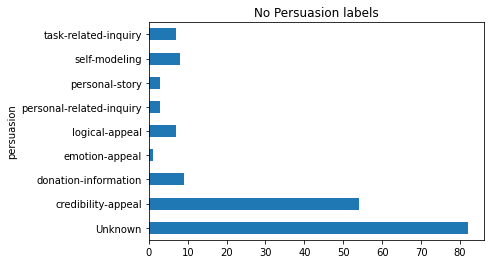

In [100]:
lkml_threads_df[['thread', 'persuasion']].groupby(['persuasion']).size().plot(
  kind='barh', rot=0, title="No Persuasion labels")

## 🔖 `Classifying` data

Categorize reconstructed email threads and then classify their communication network structure.  
Identified communication network structures will be classified into *6 possible categories*:

1. **tree:** tree like discussions
2. **atom:** email threads made of a single email
3. **comb:** email threads made of emails containing mainly patch data
4. **comets:** email threads made of emails containing a combination of patches and some comments
5. **stringy:** email threads with back and forth discussions
6. **waterfall:** email threads containing large patches

These categories are based on the categories listed in [Mailing-List-Analysis Project](https://github.com/gaalcaras/mailingListAnalysis).

In [56]:
def classify_email_threads(threads: pd.DataFrame) -> pd.DataFrame:
  """Categorize threads and then add column 'category' with thread category.
  :threads: threads pandas dataframe

  Return the categorized threads pandas dataframe
  """
  
  # 🌳 The 'default' category: pretty even tree discussions
  threads.loc[:, 'category'] = 'tree'

  # ⚛ Trivial threads with no depth (they're basically one email threads)
  threads.loc[threads.depth == 0, 'category'] = 'atom'

  # 🩹 Combs (mainly patches)
  threads.loc[threads.deg_max_2 == 0, 'category'] = 'comb'

  # ☄ Comets (combs with a tail : mainly patches and some comments)
  threads.loc[threads.deg_max_2 == 1, 'category'] = 'comet'

  # ◦◦◦◦ Stringy (back and forth threads with no star_nodes)
  threads.loc[(threads.deg_max_2 == 1) & (threads.deg_max == 1), 'category'] = 'stringy'

  # 🚿 Waterfall (huge patches)
  waterfall_cond = ((threads.h_index == 3) & (threads.deg_gini >= 0.7)) | (threads.h_index > 3)
  threads.loc[waterfall_cond, 'category'] = 'waterfall'

  return threads

In [57]:
def process_email_threads(lkml_threads_df: pd.DataFrame, debug: bool = False) -> pd.DataFrame:
  threads = lkml_threads_df.copy()
  threads = classify_email_threads(threads)

  cat_count = threads.groupby('category').size().reset_index(name='count')
  cat_count = cat_count.sort_values(by='count', ascending=False)
  cat_count['%'] = cat_count['count'] * 100 / cat_count['count'].sum()

  email_count = threads.groupby('category').emails.sum().reset_index(
      name='email_count')
  email_count['emails_%'] = email_count[
      'email_count'] * 100 / email_count['email_count'].sum()

  result = pd.merge(cat_count, email_count, on='category')
  if debug:
      sys.stdout.write(result.head(10))

  return threads

In [58]:
labeled_lkml_threads_df = process_email_threads(lkml_threads_df)

<AxesSubplot:title={'center':'No communication network patterns'}, ylabel='category'>

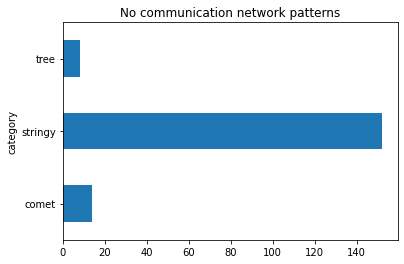

In [102]:
labeled_lkml_threads_df[['thread', 'category']].groupby(['category']).size().plot(
  kind='barh', rot=0, title="No communication network patterns")

# 🏗️ Building a Email Threads PCA Model

## 🍦 `PCA` on email threads

In [61]:
class ThreadPCA:
  def __init__(self, data_df: pd.DataFrame, features: ty.List[str], dimensions: int = 3) -> None:
    self.name = "pca"

    self.data = data_df
    self.features = features
    self.transf_fn = FunctionTransformer(log_norm_transform)
    self.data_t = self.transf_fn.transform(self.data[self.features])
    self.table = {}
    
  def fit_transform(self, dimensions: int = 3) -> ThreadPCA:
    with Stopwatch("Run PCA"):
      self.pca = PCA(dimensions)
      self.pca.fit(self.data_t)
      self.projected = self.pca.transform(self.data_t)
    
    self._build_matching_table()
    return self
  
  def _build_matching_table(self) -> None:
    """Create a table to allow matching original data points with the
    transformed data and their coordinates on each component."""

    before = self.data[self.features]

    # Create dataframe of data after transformation
    after = pd.DataFrame(data=self.data_t,
                         index=range(0, len(self.data_t)),
                         columns=self.features)
    after = after.add_suffix('_t')

    # Create dataframe of coordinates along each component
    coord = pd.DataFrame(data=self.projected,
                         index=range(0, len(self.data_t)),
                         columns=[f'PC{i+1}' for i in range(len(self.pca.components_))])

    # Bind columns from after and before
    self.table = pd.concat([after.reset_index(drop=True), before], axis=1)

    # Sort columns alphabetically
    self.table = self.table[sorted(self.table.columns.tolist())]

    # Bind columns from projected data and table
    self.table = pd.concat([coord.reset_index(drop=True), self.table], axis=1)

    # Count number of occurrences of each row and display it in 'n' column
    self.table = self.table.groupby(self.table.columns.tolist()).size().reset_index(name='n')

## 🍨 Adding `special` methods

In [88]:
# Draw correlation circle (first two components)
ThreadPCA.plot_correlation_circle = plot_correlation_circle
# Draw scatter plot (first two components), coloring threads with h_index
ThreadPCA.pca_scatter_plot = pca_scatter_plot
# Draw scree plot
ThreadPCA.scree_plot = scree_plot
# cumulative variance
ThreadPCA.plot_cumulative_variance = plot_cumulative_variance

# 🏃‍♀️ Running our Model

In [66]:
labeled_lkml_threads_copy_df = labeled_lkml_threads_df.copy()
data_filter_predicate = build_data_filter(labeled_lkml_threads_copy_df)

# Keep only threads containing {operator} {emails_in_threads} emails
email_threads_wanted = labeled_lkml_threads_copy_df[data_filter_predicate]

In [67]:
# Compute a ratio
email_threads_wanted['ratio'] = np.log1p(email_threads_wanted['depth']) / np.log1p(email_threads_wanted['emails'])

In [89]:
# Run PCA on email thread data
pca_threads = ThreadPCA(email_threads_wanted, ['star_nodes', 'ratio', 'deg_max', 'h_index', 'deg_max_2'])
pca_threads.fit_transform()

...Run PCA
...Run PCA done in 0:00:00.000994


## 🔬 Viewing results

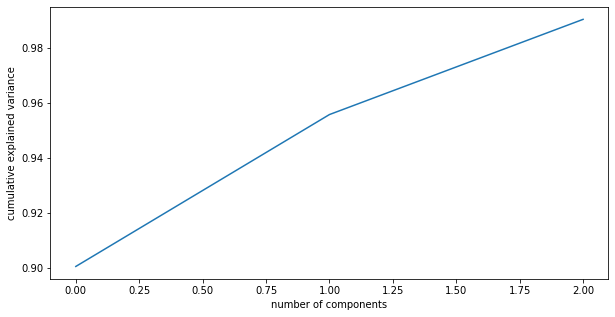

In [90]:
pca_threads.plot_cumulative_variance()

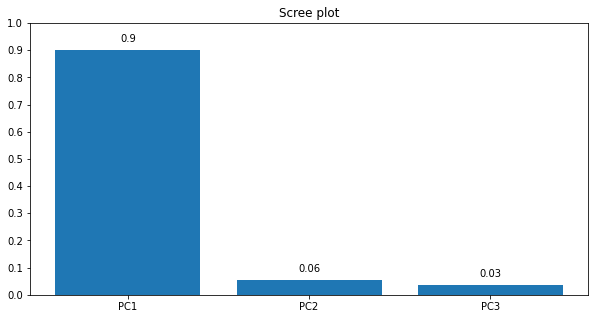

In [91]:
pca_threads.scree_plot()

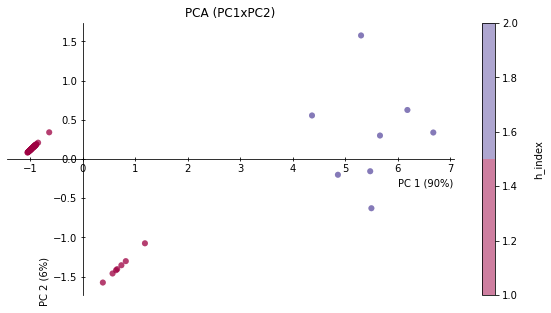

In [92]:
pca_threads.pca_scatter_plot(color='h_index')

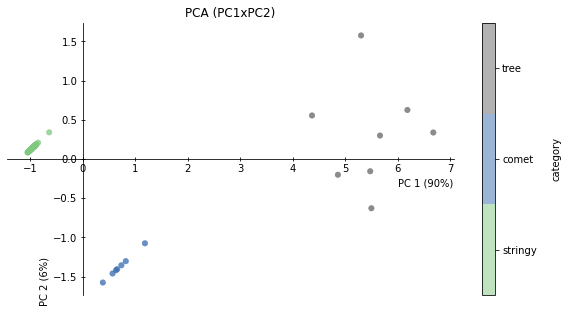

In [93]:
pca_threads.pca_scatter_plot(color='category')

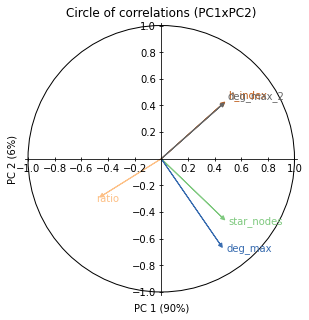

In [94]:
pca_threads.plot_correlation_circle()

In [95]:
# drawing some heatmap to explore threads data (e.g., lkml_threads_processed.csv)
email_threads_wanted_copy_df = email_threads_wanted.copy()

...heatmap_count
...heatmap_count done in 0:00:00.066589


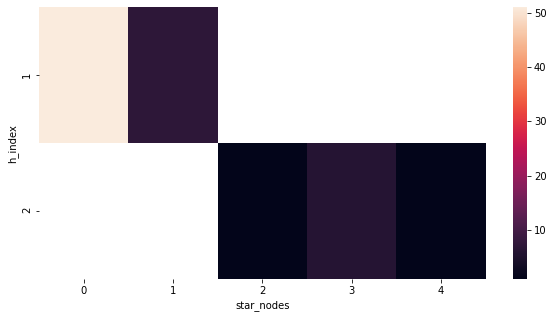

In [106]:
heatmap_count(email_threads_wanted_copy_df, ['h_index', 'star_nodes'])

...Ordered mosaic
...Ordered mosaic done in 0:00:00.040359


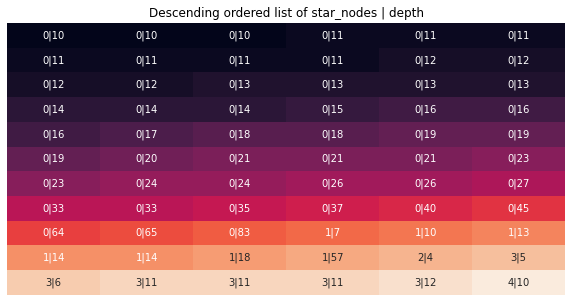

In [105]:
ordered_mosaic(email_threads_wanted_copy_df, ['star_nodes', 'depth'])